<a href="https://colab.research.google.com/github/datnguyen0328/nlp_projects/blob/main/GR1_TwitterSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
import csv
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from transformers import RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange, tqdm_notebook
from sklearn.metrics import matthews_corrcoef, f1_score

import seaborn as sns
import re
import matplotlib.pyplot as plt

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# dataset = pd.read_csv("/content/Tweets.csv")
# dataset
dataset = pd.read_csv('./Tweets.csv')
dataset.dropna(inplace=True)
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
dataset["label"] = ord_enc.fit_transform(dataset[["sentiment"]])
dataset[["sentiment", "label"]].head(11)
dataset = dataset[['text','label']]

df = pd.DataFrame(dataset)
df.dropna(subset=['text'], inplace=True)
print(df)

                                                    text  label
0                    I`d have responded, if I were going    1.0
1          Sooo SAD I will miss you here in San Diego!!!    0.0
2                              my boss is bullying me...    0.0
3                         what interview! leave me alone    0.0
4       Sons of ****, why couldn`t they put them on t...    0.0
...                                                  ...    ...
27476   wish we could come see u on Denver  husband l...    0.0
27477   I`ve wondered about rake to.  The client has ...    0.0
27478   Yay good for both of you. Enjoy the break - y...    2.0
27479                         But it was worth it  ****.    2.0
27480     All this flirting going on - The ATG smiles...    1.0

[27480 rows x 2 columns]


In [ ]:
# Strip any leading or trailing whitespaces in column names
df.columns = df.columns.str.strip()

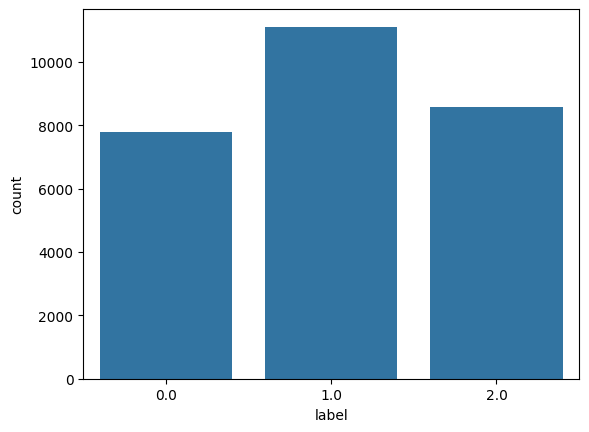

In [ ]:
sns.countplot(x='label',data=df)
plt.show()

In [ ]:
def preprocess_text(text):
  # lowercasing
  text = text.lower()

  # removing urls
  text = re.sub(r'http\S+', '', text)

  # removing punctuations
  text = re.sub(r'[^\w\s]', '', text)

  # removing users mention
  text = re.sub(r'^@\w+', '', text)

  return text

df['text'] = df['text'].apply(preprocess_text)

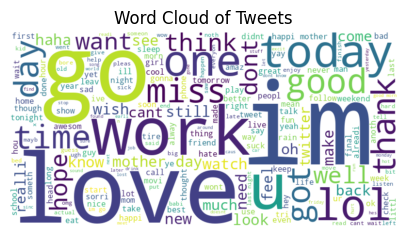

In [ ]:
# stemming
stemmer = SnowballStemmer(language = 'english')

def stem(text):
  text = text.split()
  text = [stemmer.stem(word) for word in text if not word in stopwords.words('english')]
  text = ' '.join(text)
  return text

df['text'] = df['text'].apply(stem)

# lemmatizing
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
  text = text.split()
  for word in text:
    if not word in stopwords.words('english'):
      word = lemmatizer.lemmatize(word)
  text = ' '.join(text)
  return text

df['text'] = df['text'].apply(lemmatize)

# Join text into a string
cloud_text = ' '.join(df['text'].values)
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cloud_text)
# Display the word cloud
plt.figure(figsize=(5, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

In [ ]:
#train and val split
train_df = dataset.iloc[:19236]
vall_df = dataset.iloc[19236:]
train_df.shape, vall_df.shape

((19236, 2), (8244, 2))

In [ ]:
#val test split

val_df = vall_df.iloc[:4122]
test_df = vall_df.iloc[4122:]
val_df.shape, test_df.shape

((4122, 2), (4122, 2))

In [ ]:
save_dir = ""
train_df.to_csv(save_dir + "train.csv", index=False)
val_df.to_csv(save_dir + "dev.csv", index=False)

In [ ]:
test_df.to_csv(save_dir + "test.csv", index=False)

#2. Machine learning models

In [ ]:
X_train = train_df['text'].values
X_test = test_df['text'].values
Y_train = train_df['label'].values
Y_test = test_df['label'].values

In [ ]:
print(X_train.shape, X_test.shape)

(19236,) (4122,)


In [ ]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
classifiers = {
    'LinearSVC': LinearSVC(),
    'LogisticRegression': LogisticRegression(),
    'MultinomialNB': MultinomialNB()
}

accuracy_scores = {}

for key, classifier in classifiers.items():
  classifier.fit(X_train, Y_train)
  Y_pred = classifier.predict(X_test)
  accuracy_scores[key] = accuracy_score(Y_test, Y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
for key, value in accuracy_scores.items():
  print(f'{key}: {value}')

LinearSVC: 0.6770984958757884
LogisticRegression: 0.6921397379912664
MultinomialNB: 0.6103833090732654


#3. RoBERTa model

In [ ]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [ ]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

In [ ]:

class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines

class TweetProcessor(DataProcessor):
    """Processor for the Amazon Reviews data set."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.csv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.csv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "test.csv")), "test")

    def get_labels(self):
        """See base class."""
        return [0, 1, 2]

    #Hack to be compatible with the existing code in transformers library
    def _read_tsv(self, file_path):
        return pd.read_csv(file_path).values.tolist()

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
               continue
            guid = "%s-%s" % (set_type, i)
            text_a = str(line[0])
           # text_b = None
            label = line[1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


In [ ]:
def simple_accuracy(preds, labels):
  return (preds == labels).mean()

def acc_and_f1(preds, labels):
  acc = simple_accuracy(preds, labels)
  f1 = f1_score(y_true=labels, y_pred=preds, average="micro")
  return {
      "acc": acc,
      "f1": f1,

  }


def f1_weighted(preds, labels):
  return f1_score(y_true=labels, y_pred=preds, average='weighted')

def compute_metrics(task_name, preds, labels):
  assert len(preds) == len(labels)
  if task_name == "tweet":
    return {"acc": acc_and_f1(preds, labels)}
  else:
    raise KeyError(task_name)

In [ ]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [ ]:
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer, output_mode,
                                 cls_token_at_end=False, pad_on_left=False,
                                 cls_token='[CLS]', sep_token='[SEP]', pad_token=0,
                                 sequence_a_segment_id=0, sequence_b_segment_id=1,
                                 cls_token_segment_id=1, pad_token_segment_id=0,
                                 mask_padding_with_zero=True):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):

        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = tokens_a + [sep_token]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if tokens_b:
            tokens += tokens_b + [sep_token]
            segment_ids += [sequence_b_segment_id] * (len(tokens_b) + 1)

        if cls_token_at_end:
            tokens = tokens + [cls_token]
            segment_ids = segment_ids + [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            input_mask = input_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids = segment_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if output_mode == "classification":
            label_id = label_map[example.label]
        elif output_mode == "regression":
            label_id = float(example.label)
        else:
            raise KeyError(output_mode)

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features

In [ ]:

processor = TweetProcessor()
label_list = processor.get_labels()
num_labels = len(label_list)

In [ ]:
#RobertaConfig, RobertaForSequenceClassification,RobertaTokenizer
config = RobertaConfig.from_pretrained('roberta-base', num_labels=num_labels)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', config=config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
 def load_and_cache_examples(tokenizer, dataset='train'):
  if dataset == "train":
      examples = processor.get_train_examples(data_dir)
  elif dataset == "dev":
      examples = processor.get_dev_examples(data_dir)
  else:
      examples = processor.get_test_examples(data_dir)

  features = convert_examples_to_features(examples, label_list, max_seq_length, tokenizer, output_mode,
            cls_token_at_end=True,            # xlnet has a cls token at the end
            cls_token=tokenizer.cls_token,
            sep_token=tokenizer.sep_token,
            cls_token_segment_id=2,
            pad_on_left=True,               # pad on the left for xlnet
            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
            pad_token_segment_id=4)
  # Convert to Tensors and build dataset
  all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
  all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
  all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
  if output_mode == "classification":
      all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
  elif output_mode == "regression":
      all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

  dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
  return dataset

In [ ]:
output_mode = 'classification'
max_seq_length = 60
batch_size = 8
max_grad_norm = 1.0
gradient_accumulation_steps=2
num_train_epochs= 3
weight_decay=0.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
learning_rate = 2e-5
adam_epsilon = 1e-8
num_warmup_steps = 0

In [ ]:
def calculate_accuracy(dataloader, model):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': None,
                      'labels': batch[3]}

            outputs = model(**inputs)
            logits = outputs[1]
            preds = logits.argmax(dim=1)
            labels = batch[3]

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return correct / total
def train(train_dataset, model, tokenizer, eval_dataset=None, batch_size=32, gradient_accumulation_steps=1,
          num_train_epochs=3, learning_rate=5e-5, weight_decay=0.0, adam_epsilon=1e-8, max_grad_norm=1.0,
          num_warmup_steps=0):

    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
    num_training_steps = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs

    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()

    train_iterator = tqdm_notebook(range(int(num_train_epochs)), desc="Epoch")
    set_seed(42)

    for epoch in train_iterator:
        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': None,
                      'labels': batch[3]}

            outputs = model(**inputs)
            loss = outputs[0]
            logits = outputs[1]

            if gradient_accumulation_steps > 1:
                loss = loss / gradient_accumulation_steps

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            tr_loss += loss.item()

            if (step + 1) % gradient_accumulation_steps == 0:
                scheduler.step()
                optimizer.step()
                model.zero_grad()
                global_step += 1

        # Calculate training accuracy
        train_acc = calculate_accuracy(train_dataloader, model)

        # Print training loss and accuracy
        print(f"Epoch {epoch + 1}/{num_train_epochs}:")
        print(f"  Training Loss: {tr_loss / global_step:.4f}")
        print(f"  Training Accuracy: {train_acc:.4f}")

        # Evaluate on validation set if provided
        if eval_dataset is not None:
            eval_acc = evaluate(model, tokenizer, prefix=global_step)
            print(f"  Evaluation Accuracy: {eval_acc}")

    return global_step, tr_loss / global_step


In [ ]:
def evaluate(model, tokenizer, prefix=""):
  results = {}
  eval_dataset = load_and_cache_examples(tokenizer, dataset='dev')
  eval_batch_size = 8
  eval_sampler = SequentialSampler(eval_dataset)
  eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)
  eval_loss = 0.0
  nb_eval_steps = 0
  preds = None
  out_label_ids = None
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': None,             # XLM and RoBERTa don't use segment_ids
                'labels':         batch[3]}
      outputs = model(**inputs)
      tmp_eval_loss, logits = outputs[:2]
      eval_loss += tmp_eval_loss.mean().item()

    nb_eval_steps += 1
    if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
  eval_loss = eval_loss / nb_eval_steps
  if output_mode == "classification":
      preds = np.argmax(preds, axis=1)
  elif output_mode == "regression":
      preds = np.squeeze(preds)
  result = compute_metrics("tweet", preds, out_label_ids)
  return result

In [ ]:
data_dir= ''
model.to(device)
train_dataset = load_and_cache_examples(tokenizer, dataset="train")
global_step, tr_loss = train(train_dataset, model, tokenizer, eval_dataset=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-32-e3d6b4c15436>:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  train_iterator = tqdm_notebook(range(int(num_train_epochs)), desc="Epoch")


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-32-e3d6b4c15436>:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")


Iteration:   0%|          | 0/602 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/3:
  Training Loss: 0.6723
  Training Accuracy: 0.8108


<ipython-input-33-e263af13df3d>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):


Evaluating:   0%|          | 0/516 [00:00<?, ?it/s]

  Evaluation Accuracy: {'acc': {'acc': 0.7597670468332929, 'f1': 0.7597670468332929}}


<ipython-input-32-e3d6b4c15436>:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")


Iteration:   0%|          | 0/602 [00:00<?, ?it/s]

Epoch 2/3:
  Training Loss: 0.5774
  Training Accuracy: 0.8821


<ipython-input-33-e263af13df3d>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):


Evaluating:   0%|          | 0/516 [00:00<?, ?it/s]

  Evaluation Accuracy: {'acc': {'acc': 0.7850036398932297, 'f1': 0.7850036398932297}}


<ipython-input-32-e3d6b4c15436>:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")


Iteration:   0%|          | 0/602 [00:00<?, ?it/s]

Epoch 3/3:
  Training Loss: 0.5054
  Training Accuracy: 0.9119


<ipython-input-33-e263af13df3d>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):


Evaluating:   0%|          | 0/516 [00:00<?, ?it/s]

  Evaluation Accuracy: {'acc': {'acc': 0.7830623635040039, 'f1': 0.7830623635040039}}


In [ ]:
# Evaluation
result = evaluate(model, tokenizer, prefix=global_step)
print(result)

<ipython-input-33-e263af13df3d>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):


Evaluating:   0%|          | 0/516 [00:00<?, ?it/s]

{'acc': {'acc': 0.7830623635040039, 'f1': 0.7830623635040039}}


In [ ]:
def evaluatetest(model, tokenizer, prefix=""):
  results = {}
  eval_dataset = load_and_cache_examples(tokenizer, dataset='test')
  eval_batch_size = 8
  eval_sampler = SequentialSampler(eval_dataset)
  eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)
  eval_loss = 0.0
  nb_eval_steps = 0
  preds = None
  out_label_ids = None
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': None,             # XLM and RoBERTa don't use segment_ids
                'labels':         batch[3]}
      outputs = model(**inputs)
      tmp_eval_loss, logits = outputs[:2]
      eval_loss += tmp_eval_loss.mean().item()

    nb_eval_steps += 1
    if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
  eval_loss = eval_loss / nb_eval_steps
  if output_mode == "classification":
      preds = np.argmax(preds, axis=1)
  elif output_mode == "regression":
      preds = np.squeeze(preds)
  result = compute_metrics("tweet", preds, out_label_ids)
  return result

In [ ]:
# Evaluation
result = evaluatetest(model, tokenizer, prefix=global_step)
print(result)

<ipython-input-36-f71e6671c8a4>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):


Evaluating:   0%|          | 0/516 [00:00<?, ?it/s]

{'acc': {'acc': 0.7789371511768988, 'f1': 0.7789371511768987}}
